0 11
1 26
2 46


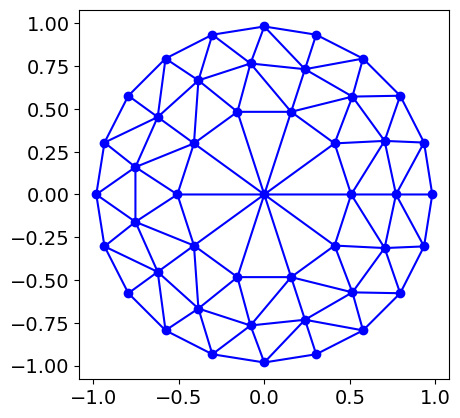

In [121]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import scipy.spatial as spatial
# distribute random points inside unit disc

rings = 3
border = 0.97
dist = (border - 0.0) / rings

points = []
points.append([0, 0])
for r_i, r in enumerate(
    (np.linspace(0.0, border, rings + 1, endpoint=True)[1:]) ** (0.6)
):
    amount = int(np.ceil(r * 2 * np.pi / dist))
    # amount = 6
    for angle in np.linspace(0, 2 * np.pi, amount, endpoint=False):
        points.append([r * np.cos(angle), r * np.sin(angle)])
    print(r_i, len(points))

points = np.array(points)
# triangulate the points
delaunay = spatial.Delaunay(points)

triang = mtri.Triangulation(
    [p[0] for p in points], [p[1] for p in points], delaunay.simplices
)
# plot the triangulation
plt.figure()

plt.gca().set_aspect("equal")
plt.triplot(triang, "bo-")
plt.show()


# create a mesh from the triangulation
mesh = trimesh.Trimesh(vertices=points, faces=triang.triangles)


# save as obj
mesh.export("../../meshes/small-disc.obj");

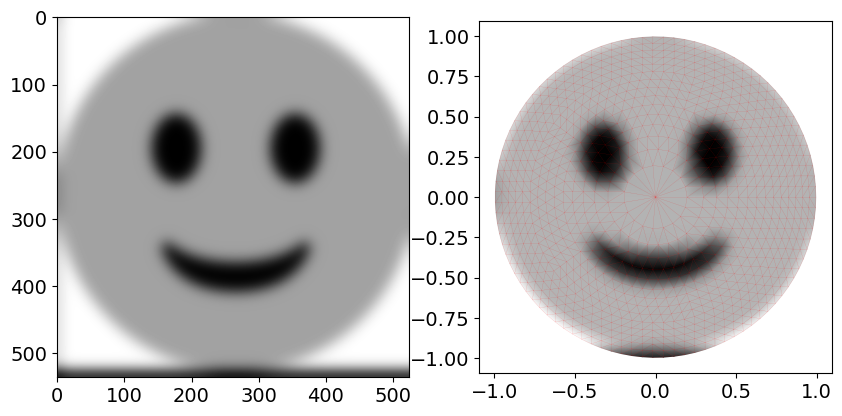

In [48]:
# load smiley.png with numpy
image = plt.imread("../../smiley2.png")
# make grayscale
image = image.mean(axis=2)
# blur image
import scipy.ndimage

image = scipy.ndimage.gaussian_filter(image, 10)
globe_width = image.shape[1]
globe_height = image.shape[0]

import DEC as dm

mesh = dm.Mesh.from_obj("../../meshes/small-disc.obj")

# get all barycenters:
barycenters = np.mean(mesh.vertices[:, [0, 2]][triang.triangles], axis=1)
barycenters = mesh.vertices[:, [0, 2]]

# get interpolated color at each vertex
colors = scipy.ndimage.map_coordinates(
    image,
    [
        globe_height - globe_height * (barycenters[:, 1] / 2 + 0.5),
        globe_width * (barycenters[:, 0] / 2 + 0.5),
    ],
    order=1,
    mode="nearest",
)

edge_values = mesh.d0 @ colors

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[1].tripcolor(triang, colors, cmap="gray", shading="gouraud")
# plot mesh
ax[1].triplot(triang, "r-", lw=0.1, alpha=0.5)

ax[0].imshow(image, cmap="gray")
plt.show()

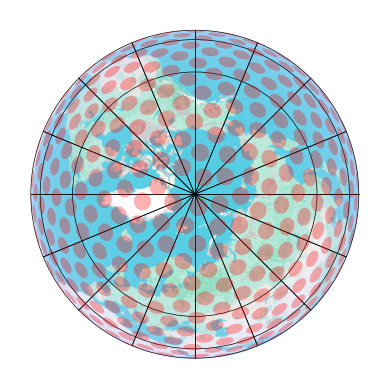

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


def draw_metric_ellipses(metric_tensor_function, points, chart_bounds=(-1, 1)):
    """
    Draw ellipses representing a 2D metric tensor at specified points in a coordinate chart.

    Args:
        metric_tensor_function (function): A function that takes (x, y) and returns a 2x2 metric tensor.
        points (list of tuples): A list of (x, y) coordinates where ellipses should be drawn.
        chart_bounds (tuple): The bounds of the coordinate chart (xmin, xmax).
    """

    # Plot the ellipses at the specified points
    coll = []
    for point in points:
        x, y = point
        g = metric_tensor_function(point)  # Get the metric tensor at the point

        # Ensure the tensor is 2x2
        assert g.shape == (2, 2), "Metric tensor must be a 2x2 matrix."

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(g)

        # Get the ellipse parameters
        width = 2 * np.sqrt(
            eigenvalues[0]
        )  # Major axis (proportional to sqrt of eigenvalue)
        height = 2 * np.sqrt(eigenvalues[1])  # Minor axis
        angle = np.degrees(
            np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
        )  # Rotation angle in degrees

        # Create and add the ellipse patch
        ellipse = Ellipse(
            (x, y),
            width,
            height,
            angle=angle,
            edgecolor="none",
            facecolor="red",
            lw=0,
            alpha=0.3,
        )

        coll.append(ellipse)
    ax.add_collection(PatchCollection(coll, match_original=True, zorder=0))

    # Set chart bounds
    xmin, xmax = chart_bounds
    ymin, ymax = chart_bounds
    ex = 1.14
    ax.set_aspect("equal")
    # ax.grid(True)
    # ax.set_title("Ellipses Representing Inverse Metric Tensor")
    ax.set_xlabel("x")
    ax.set_ylabel("y")


import jax
import jax.numpy as jnp


def embed_to_dome(point):
    return jnp.array([point[0], point[1], jnp.sqrt(1 - jnp.linalg.norm(point) ** 2)])


# Example Usage
@jax.jit
def projected_dome_tensor(point):
    jacobian = jax.jacobian(embed_to_dome)
    norm = jnp.linalg.norm(point)
    return 0.003 * jax.lax.cond(
        norm <= 1,
        lambda _: jax.lax.cond(
            norm == 0,
            lambda _: jnp.eye(2),
            lambda _: jnp.linalg.inv(jacobian(point).T @ jacobian(point)),
            # lambda _: jacobian(point).T @ jacobian(point),
            operand=None,
        ),
        lambda _: jnp.zeros((2, 2)),
        operand=None,
    )


# Points where the ellipses will be drawn
xs = np.linspace(-1, 1, 20)
ys = np.linspace(-1, 1, 20)
points = jnp.array([(x, y) for x in xs for y in ys])
points = points[points[:, 0] ** 2 + points[:, 1] ** 2 < 1]


def sunflower_spiral_pattern_2D(n: int, radius: float = 1.0) -> np.ndarray:
    """
    Generate the points of a sunflower spiral pattern in 2D.
    Args:
        n (int): The number of points to generate.
    Returns:
        np.ndarray: An array of shape (n, 2) containing the points of the sunflower spiral pattern.
    """
    # Golden ratio
    phi = (1 + np.sqrt(5)) / 2
    # Generate the points
    indices = np.arange(0, n, dtype=np.float32)
    r = np.sqrt(1 - ((indices / n) ** 2)) * radius
    theta = 2 * np.pi * phi * indices
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.stack([x, y], axis=-1)


image = plt.imread("../../globe_projection.png")

ex = 1.127
adj = -0.02
fig, ax = plt.subplots()
ax.imshow(image, extent=(-ex + adj, ex - adj, -ex - adj, ex + adj), zorder=-20)
ax.set_xlim(-ex, ex)
ax.set_ylim(-ex, ex)

points = [
    np.array([np.cos(theta), np.sin(theta)])
    for theta in np.linspace(0, 2 * np.pi, 16, endpoint=False)
]

for point in points:
    start = [point[0], -point[0]]
    end = [point[1], -point[1]]
    ax.plot(start, end, color="black", zorder=-20, lw=0.5)

ks = np.linspace(0, 1, 4, endpoint=True)[::-1]
coll = []
for k in ks:
    circle = plt.Circle((0, 0), np.sqrt(1 - k * k), color="black", fill=False, lw=0.5)

    coll.append(circle)

from matplotlib.collections import PatchCollection

points = [(0, 0)]
points.extend(
    [
        r * np.array([np.cos(theta), np.sin(theta)])
        for r in np.sqrt(1 - ks**2)
        for theta in np.linspace(0, 2 * np.pi, 16, endpoint=False)
    ]
)

points = jnp.array(points)
ax.add_collection(PatchCollection(coll, match_original=True, zorder=-10))
# ax.axis("off")
# circle = ax.add_patch(plt.Circle((0, 0), 1, color="black", fill=False, lw=0.5))

# Draw the metric ellipses
points = sunflower_spiral_pattern_2D(300, 1.0)
draw_metric_ellipses(projected_dome_tensor, points)
# plt.scatter(points[:, 0], points[:, 1])
# ax.imshow(image, extent=(-ex + adj, ex - adj, -ex - adj, ex + adj), zorder=-20)
ax.set_xlim(-ex, ex)
ax.set_ylim(-ex, ex)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis("off")
fig.savefig(
    "../../markdown/latex/images/hemisphere_tissot_indicatrix.png",
    dpi=200,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0.1,
)

SyntaxError: invalid syntax (3861319377.py, line 137)

1334 1282


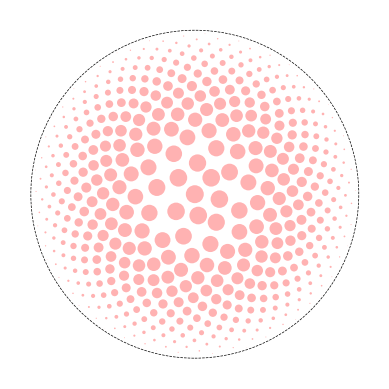

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Points where the ellipses will be drawn
xs = np.linspace(-1, 1, 40)
ys = np.linspace(-1, 1, 40)
points = jnp.array([(x, y) for x in xs for y in ys])
points = points[points[:, 0] ** 2 + points[:, 1] ** 2 < 1]


def embed_to_bell(point):
    scale = jnp.array([[0.1, 0.1], [0.1, 0.8]]) * 0.5
    z = jnp.exp(-((jnp.linalg.norm(point @ jnp.linalg.inv(scale) @ point)) ** 2))
    return jnp.array([point[0], point[1], z])


# Example Usage
@jax.jit
def projected_bell_metric(point):
    jacobian = jax.jacobian(embed_to_bell)
    return jnp.linalg.inv(jacobian(point).T @ jacobian(point)) * 0.002


smiley_image = plt.imread("../../smiley2.png")
smiley_image = smiley_image.mean(axis=2)
smiley_image = scipy.ndimage.gaussian_filter(smiley_image, 10)
smiley_width = smiley_image.shape[1]
smiley_height = smiley_image.shape[0]

print(globe_width, globe_height)


def smiley_metric(point):
    coordinates = (
        jnp.array(
            [
                smiley_height - smiley_height * (point[1] / 2 + 0.5),
                smiley_width * (point[0] / 2 + 0.5),
            ]
        )
        .reshape(2, 1)
        .tolist()
    )
    interp = scipy.ndimage.map_coordinates(
        smiley_image,
        coordinates,
        order=1,
        mode="nearest",
    )
    return jnp.eye(2) * (0.01 + 5 * interp)


globe_image = plt.imread("../../globe_projection.png")
globe_image = globe_image.mean(axis=2)
globe_image = scipy.ndimage.gaussian_filter(globe_image, 10)
globe_width = globe_image.shape[1]
globe_height = globe_image.shape[0]


def globe_picture_metric(point):
    coordinates = (
        jnp.array(
            [
                globe_height - globe_height * (point[1] / 2 + 0.5),
                globe_width * (point[0] / 2 + 0.5),
            ]
        )
        .reshape(2, 1)
        .tolist()
    )
    interp = scipy.ndimage.map_coordinates(
        globe_image,
        coordinates,
        order=1,
        mode="nearest",
    )
    return jnp.eye(2) * interp


# circle = ax.add_patch(
#     plt.Circle((0, 0), 1, color="black", fill=False, lw=0.5, linestyle="--")
# )
ex = 1.127
adj = -0.02
# fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
fig, ax = plt.subplots()
ax.set_xlim(-ex, ex)
ax.set_ylim(-ex, ex)

rectangle = plt.Rectangle(
    (-1, -1),
    2,
    2,
    color="black",
    fill=False,
    lw=0.5,
    linestyle="--",
)


def sunflower_spiral_pattern_2D(n: int, radius: float = 1.0) -> np.ndarray:
    """
    Generate the points of a sunflower spiral pattern in 2D.
    Args:
        n (int): The number of points to generate.
    Returns:
        np.ndarray: An array of shape (n, 2) containing the points of the sunflower spiral pattern.
    """
    # Golden ratio
    phi = (1 + np.sqrt(5)) / 2
    # Generate the points
    indices = np.arange(0, n, dtype=np.float32)
    r = ((indices / n) ** 0.3) * radius
    theta = 2 * np.pi * phi * indices
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.stack([x, y], axis=-1)


points = sunflower_spiral_pattern_2D(500, radius=1)
points = points[
    (points[:, 0] <= 1)
    & (points[:, 1] <= 1)
    & (points[:, 0] >= -1)
    & (points[:, 1] >= -1)
]
circle = plt.Circle(
    (0, 0),
    1,
    color="black",
    fill=False,
    lw=0.5,
    linestyle="--",
)
ax.add_patch(circle)

# Draw the metric ellipses
# draw_metric_ellipses(lambda point: 1.0 * projected_bell_metric(point), points)

points = (
    list(points) + [[-0.1, 0.1]] + [[0.1, 0.1]] + [[0.15, -0.03]] + [[0.021, -0.13]]
)

draw_metric_ellipses(
    lambda point: 0.003 * jnp.linalg.inv(hyperbolic_metric(point)), np.array(points)
)
# draw_metric_ellipses(
#     lambda point: 0.25 * (hyperbolic_metric(point)),
#     points,
# )

plt.axis("off")
fig.savefig(
    "../../markdown/latex/images/hyperbolic_space_tissot.png",
    dpi=200,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0.1,
)